In [267]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

'2.6.0+cu124'

#### 1. Data (Preparing and loading)
1. Turn data into numbers
2. Build a model to learn the presentation as best as possible

In [268]:
weight, bias = 0.7, 0.3
X = torch.arange(
    start = 0, end = 1, step = 0.01
).unsqueeze(dim = 1)
X.shape
y = X * weight + bias
noise = torch.rand_like(y) * 0.1
y += noise

#### Split data into training and test sets
- Training set: The model learns from this data, amound of total data: 60 - 80%
- Validation set: The model gets tuned on this data, amound: 10 - 20%
- Testing set: The model get evaluated on this data to test what is has learned, amound: 10 - 20%

In [269]:
# Create train/valid/test split
train_size, val_size, test_size = int(len(y) * 0.6), int(len(y) * 0.2), int(len(y) * 0.2)
train_data = X[:train_size]
test_data = X[train_size:(train_size + test_size)]
val_data = X[len(test_data):]

train_label = y[:train_size]
test_label = y[train_size:(train_size + test_size)]
val_label = y[len(test_data):]

train_data.shape, test_data.shape, val_data.shape

(torch.Size([60, 1]), torch.Size([20, 1]), torch.Size([80, 1]))

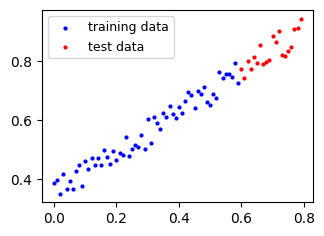

In [270]:
def plot(
        train_data, train_label,
        test_data, test_label, 
        # valid_data, valid_label, 
        pred = None
):
    plt.figure(figsize = (3.5, 2.5))

    # Plot training data in blue
    plt.scatter(train_data, train_label, c = 'b', s = 4, label = 'training data')

    plt.scatter(test_data, test_label, c = 'r', s = 4, label = 'test data')
    
    if pred is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.plot(np.concatenate((train_data, test_data)), pred, c="g", label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 9})

plot(train_data, train_label, test_data, test_label)

In [271]:
from torch import tensor

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype = torch.float32), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float32), requires_grad = True)
    def forward(self, x: torch.Tensor):
        return self.weight * x + self.bias


#### Pytorch module:
- torch.nn: Contains all of the building blocks for computational graph
- torch.nn.Parameter: Stores tensors that can be used with nn.Module. If require_grad = True then gradients will be calculated automatically.
- torch.nn.Module: The base class of all neural network modules, all the building blocks for neural networks are subclasses. If you are building a neural netword in PyTorch, your models should subclass nn.Module, requires a forward() method to be implemented.
- torch.optim: Contains various optimization algorithm which impove gradient descent and in turn reduce the loss.

In [272]:
torch.manual_seed(seed = 42)

model = LinearRegressionModel()

list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [273]:
model.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Make predictions with model
- Using torch.inference_mode()
- torch.inference_mode() is used when using a model for inference (making predictions). It turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes faster.
-  In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred. See this Tweet from PyTorch for more.

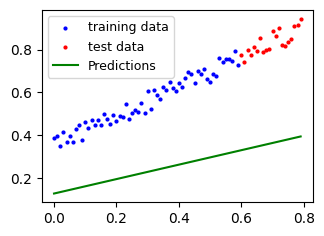

In [274]:
with torch.inference_mode():
    y_pred = model(np.concatenate((train_data, test_data)))
plot(
    train_data, train_label, test_data, test_label, pred = y_pred
)

- Loss function: Measure how wrong your model's prediction are compare to the truth labels. __Lower the better__
- Optimizer: Tells your model how to update its internal parameters to best lower the loss.

In [275]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)


#### Training loop
1. Forward pass: The model goes through all the training data once performing its forward() function calculations.
2. Calculate the loss: The model output are compared to the ground truth and evaluate to see how wrong they are.
3. Zero gradient: The optimizers gradient are set to zero so they can be recalculated for the specific training step.
4. Backpropagation: Compute the gradient of the loss with respect to every model paramater to be updated.
5. Update the optimizer: Update the parameters with requires_grad = True.

#### Testing loop
1. Forward pass
2. Calculate the loss
3. Calculate evaluation metrics

In [276]:
torch.manual_seed(42)

num_epochs = 500

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(num_epochs):
    model.train() # Put the model in training mode

    #1. Forward pass on training data using the forward method inside
    y_pred = model(train_data)

    #2. Calculate the loss
    loss = loss_fn(y_pred, train_label)

    #3. Zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
        #1. Forward pass on test data
        test_pred = model(test_data)

        #2. Calculate loss on test_data
        test_loss = loss_fn(test_pred, test_label)

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epochs: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")

Epochs: 0 | MSE Train Loss: 0.33340051770210266 | MSE Test Loss: 0.45914825797080994
Epochs: 10 | MSE Train Loss: 0.22469790279865265 | MSE Test Loss: 0.33864569664001465
Epochs: 20 | MSE Train Loss: 0.11599542200565338 | MSE Test Loss: 0.21814313530921936
Epochs: 30 | MSE Train Loss: 0.04881672561168671 | MSE Test Loss: 0.13121671974658966
Epochs: 40 | MSE Train Loss: 0.042827192693948746 | MSE Test Loss: 0.10535764694213867
Epochs: 50 | MSE Train Loss: 0.04050393030047417 | MSE Test Loss: 0.09324774146080017
Epochs: 60 | MSE Train Loss: 0.038838643580675125 | MSE Test Loss: 0.08791683614253998
Epochs: 70 | MSE Train Loss: 0.03717335686087608 | MSE Test Loss: 0.08258593827486038
Epochs: 80 | MSE Train Loss: 0.0355113260447979 | MSE Test Loss: 0.07689851522445679
Epochs: 90 | MSE Train Loss: 0.03402118384838104 | MSE Test Loss: 0.07174846529960632
Epochs: 100 | MSE Train Loss: 0.03269578143954277 | MSE Test Loss: 0.066395103931427
Epochs: 110 | MSE Train Loss: 0.03174654766917229 | MSE

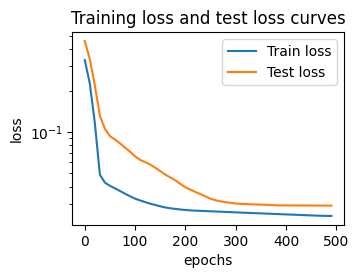

In [277]:
plt.figure(figsize = (3.5, 2.5))
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.yscale('log')
plt.title(label = "Training loss and test loss curves")
plt.legend()

In [278]:
print(model.state_dict())
print("weight = ", weight)
print("bias = ", bias)

OrderedDict([('weight', tensor([0.6693])), ('bias', tensor([0.3671]))])
weight =  0.7
bias =  0.3


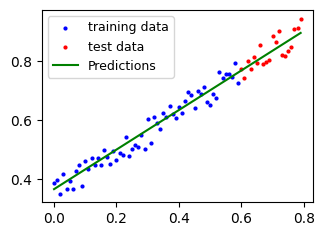

In [279]:
with torch.inference_mode():
    y_pred = model(np.concatenate((train_data, test_data)))
plot(
    train_data, train_label, test_data, test_label, pred = y_pred
)